In [1]:
!pip install wandb

# **here we a login into wandb for weight and biases**

In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: partho-dutta2004 (partho-dutta2004-graphic-era-hill-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# **Unzipping Dataset**

In [3]:
from google.colab import files
uploaded = files.upload()

import zipfile
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref: # uploading the given dataset and then unzipping it for further process
    zip_ref.extractall('dataset')

Saving dataset.zip to dataset (1).zip


In [4]:
import os
import json
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import wandb
wandb.init(project="ayna-polygon-colorizer", name="unet-colab-run")

# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# **Transforming and using encoding to asign value to colours**

In [5]:
class PolygonDataset(Dataset):
    def __init__(self, data_json_path, input_dir, output_dir, color_dict, transform=None):
        with open(data_json_path, "r") as f:
            self.data = json.load(f)
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform
        self.color_dict = color_dict

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        polygon_path = os.path.join(self.input_dir, sample['input_polygon'])
        output_path = os.path.join(self.output_dir, sample['output_image'])
        color_name = sample['colour']

        polygon_img = Image.open(polygon_path).convert('RGB')
        output_img = Image.open(output_path).convert('RGB')

        if self.transform:
            polygon_img = self.transform(polygon_img)
            output_img = self.transform(output_img)

        color_tensor = torch.tensor(self.color_dict[color_name], dtype=torch.float32)

        return {
            "polygon": polygon_img,
            "color": color_tensor,
            "target": output_img
        }

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

color_dict = {
    "red": [1, 0, 0],
    "green": [0, 1, 0],
    "blue": [0, 0, 1],
    "yellow": [1, 1, 0],
    "cyan": [0, 1, 1],
    "magenta": [1, 0, 1],
    "orange": [1, 0.5, 0],
    "purple": [0.5, 0, 0.5]
}


In [7]:
train_dataset = PolygonDataset(
    data_json_path="/content/dataset/dataset/training/data.json",
    input_dir="/content/dataset/dataset/training/inputs",
    output_dir="/content/dataset/dataset/training/outputs",
    color_dict=color_dict,
    transform=transform
)

val_dataset = PolygonDataset(
    data_json_path="/content/dataset/dataset/validation/data.json",
    input_dir="/content/dataset/dataset/validation/inputs",
    output_dir="/content/dataset/dataset/validation/outputs",
    color_dict=color_dict,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# **UNet Model Implementation**

In [8]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=3):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))  # output image with 3 channels


In [9]:
model = UNet(in_channels=6, out_channels=3).to(device)

# **Loss Function & Optimizer and Model Training Loop**

---


In [10]:
import torch.optim as optim
import wandb

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        poly_img = batch['polygon'].to(device)
        color_vec = batch['color'].to(device)
        target_img = batch['target'].to(device)

        # Create color image tensor
        color_img = color_vec.view(-1, 3, 1, 1).repeat(1, 1, 128, 128)

        # Concatenate inputs
        input_tensor = torch.cat((poly_img, color_img), dim=1)

        # Forward pass
        output = model(input_tensor)
        loss = criterion(output, target_img)

        # Backward pass + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    try:
        wandb.log({"Epoch": epoch + 1, "Loss": avg_loss})
    except Exception as e:
        print("W&B log error:", e)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.2531
Epoch [2/20], Loss: 0.2304
Epoch [3/20], Loss: 0.2114
Epoch [4/20], Loss: 0.1981
Epoch [5/20], Loss: 0.1842
Epoch [6/20], Loss: 0.1695
Epoch [7/20], Loss: 0.1610
Epoch [8/20], Loss: 0.1516
Epoch [9/20], Loss: 0.1455
Epoch [10/20], Loss: 0.1394
Epoch [11/20], Loss: 0.1362
Epoch [12/20], Loss: 0.1384
Epoch [13/20], Loss: 0.1285
Epoch [14/20], Loss: 0.1298
Epoch [15/20], Loss: 0.1238
Epoch [16/20], Loss: 0.1270
Epoch [17/20], Loss: 0.1152
Epoch [18/20], Loss: 0.1133
Epoch [19/20], Loss: 0.1144
Epoch [20/20], Loss: 0.1114


# **Inference & Visualization**

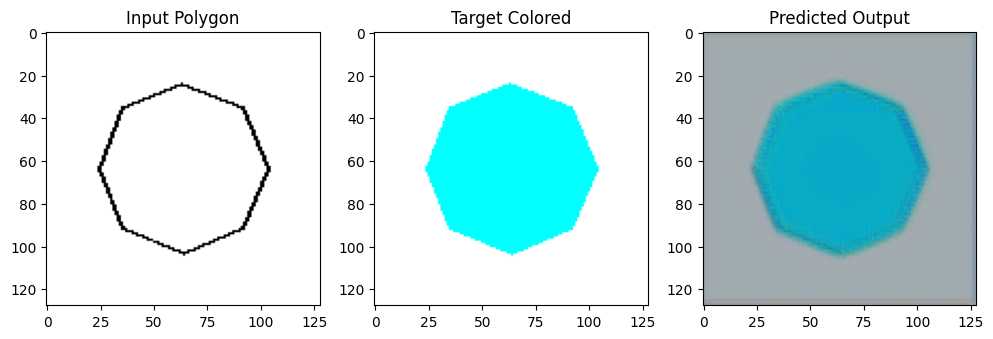

In [11]:
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

# Get one sample from the test set (or train set if you don’t have test set)
sample = train_dataset[0]

# Prepare input
polygon = sample['polygon'].unsqueeze(0).to(device)           # [1, 3, H, W]
color_vec = sample['color'].unsqueeze(0).to(device)           # [1, 3]
color_img = color_vec.view(-1, 3, 1, 1).repeat(1, 1, 128, 128) # [1, 3, H, W]
input_tensor = torch.cat((polygon, color_img), dim=1)         # [1, 6, H, W]

# Predict
with torch.no_grad():
    output = model(input_tensor).squeeze(0).cpu()             # [3, H, W]

# Convert tensors to numpy images
def to_numpy(tensor_img):
    return np.transpose(tensor_img.numpy(), (1, 2, 0))

pred_img = to_numpy(output).clip(0, 1)
input_polygon = to_numpy(sample['polygon'])
target_img = to_numpy(sample['target'])

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input Polygon")
plt.imshow(input_polygon)

plt.subplot(1, 3, 2)
plt.title("Target Colored")
plt.imshow(target_img)

plt.subplot(1, 3, 3)
plt.title("Predicted Output")
plt.imshow(pred_img)

plt.show()


In [17]:
# Function to load and prepare image + color
def predict_polygon_color(polygon_image_path, color_name, model, color_dict, transform):
    model.eval()

    image = Image.open(polygon_image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    color_vector = torch.tensor(color_dict[color_name], dtype=torch.float32).view(1, 3, 1, 1).to(device)
    color_img = color_vector.repeat(1, 1, 128, 128)

    input_tensor = torch.cat((image, color_img), dim=1)

    with torch.no_grad():
        output = model(input_tensor).squeeze(0).cpu()

    output_image = transforms.ToPILImage()(output.clamp(0, 1))
    return output_image


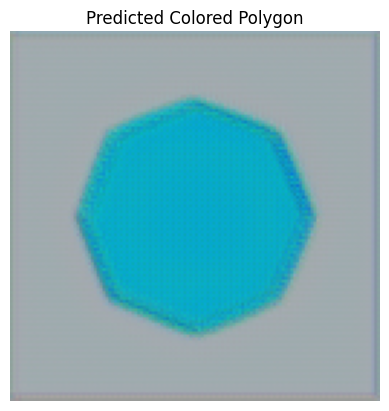

In [18]:
# Example
test_path = "/content/dataset/dataset/validation/inputs/octagon.png"
pred_img = predict_polygon_color(test_path, "cyan", model, color_dict, transform)

# display result
plt.imshow(pred_img)
plt.axis("off")
plt.title("Predicted Colored Polygon")
plt.show()


In [14]:
import ipywidgets as widgets
from IPython.display import display

shape_widget = widgets.Dropdown(options=["triangle", "square", "octagon","star","circle","diamond","hexagon","pentagon"], description='Shape:')
color_widget = widgets.Dropdown(options=list(color_dict.keys()), description='Color:')
display(shape_widget, color_widget)

Dropdown(description='Shape:', options=('triangle', 'square', 'octagon', 'star', 'circle', 'diamond', 'hexagon…

Dropdown(description='Color:', options=('red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'purple…

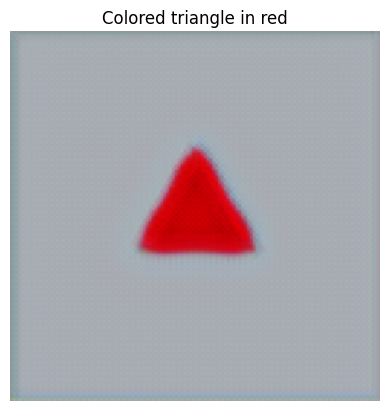

In [15]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load the selected polygon image for visualization
input_path = f"/content/dataset/dataset/training/inputs/{shape_widget.value}.png"
polygon_img = Image.open(input_path).convert("RGB")
polygon_tensor = transform(polygon_img).unsqueeze(0).to(device)  # Shape: [1, 3, 128, 128]

# Get the selected color and create color tensor
color_tensor = torch.tensor(color_dict[color_widget.value], dtype=torch.float32).view(1, 3, 1, 1)
color_tensor = color_tensor.repeat(1, 1, 128, 128).to(device)  # Shape: [1, 3, 128, 128]

# Combine inputs
input_tensor = torch.cat((polygon_tensor, color_tensor), dim=1)  # Shape: [1, 6, 128, 128]

# Generate output from the model
model.eval()
with torch.no_grad():
    output = model(input_tensor).squeeze(0).cpu().permute(1, 2, 0).numpy()

# Display the output image
plt.imshow(output)
plt.axis("off")
plt.title(f"Colored {shape_widget.value} in {color_widget.value}")
plt.show()


In [16]:
torch.save(model.state_dict(), "unet_polygon_colorizer.pth")
